# Hands-On Pytorch Geometric

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%202%20-%20Graph%20Neural%20Networks/pytorch-geometric.ipynb)

En este notebook vamos a explorar un poco la librería [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), la cual está diseñada para trabajar precisamente con Graph Neural Networks. El alcance de este notebook es sencillamente familiarizarnos con la librería, explorar uno de sus datasets, estructuras y algo de visualización. Finalmente, entrenaremos un modelo MLP para una tarea de clasificación de nodos.

#### Referencias
- [Introduction: Hands-On Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing)
- [Pytorch Geometric - Colab Notebooks and Video Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)
- [Revisiting Semi-Supervised Learning with Graph Embeddings](https://arxiv.org/abs/1603.08861)

In [6]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [21]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%202%20-%20Graph%20Neural%20Networks/requirements.txt && pip install -r requirements.txt

In [8]:
if IN_COLAB:
    import torch

    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Funciones utilitarias

Primero, definimos unas cuantas funciones utilitarias para obtener información de los datos.

In [9]:
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
from typing import Optional, Any
from torch_geometric.data import Dataset
from torch_geometric.data.data import BaseData

def visualize_graph(G, color: str):
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, k=0.15, iterations=200, seed=1234),
        node_size=10,
        with_labels=False,
        node_color=color,
        cmap="Set2",
        width=0.15
    )
    plt.show()


def print_dataset_summary(dataset: Dataset):
    print(f'Dataset: {dataset}')
    print(f'=' * 20)
    print(f'Número de grafos: {len(dataset)}')
    print(f'Número de features: {dataset.num_features}')
    print(f'Número de clases: {dataset.num_classes}')


def print_graph_summary(data: BaseData):
    print(f'=' * 50)
    print(f'Número de nodos: {data.num_nodes}')
    print(f'Número de conexiones: {data.num_edges}')
    print(f'Grado promedio: {data.num_edges / data.num_nodes:.2f}')
    print(f'Número de nodos para entrenamiento: {data.train_mask.sum()}')
    print(f'Proporción de todos de entrenamiento: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Tiene nodos aislados?: {data.has_isolated_nodes()}')
    print(f'Tiene nodos con bucles propios?: {data.has_self_loops()}')
    print(f'Es no dirigido?: {data.is_undirected()}')


## Planetoid Cora Dataset

Este dataset es el equivalente al MNIST para graph learning. Consiste en una red de publicaciones cientificas y su respectivo tema que los caracteriza. En el subconjunto que vamos a usar en este notebook, hay siete categorías de publicaciones, organizadas de la siguiente manera:

- 0: Theory
- 1: Reinforcement Learning
- 2: Genetic Algorithms
- 3: Neural Networks
- 4: Probabilistic Methods
- 5: Case Based
- 6: Rule Learning

La librería Pytorch Geometric implementa unas funciones que nos facilitan la obtención y trabajo de este dataset. Y con ayuda de las funciones que hemos definido arriba, podrémos obtener información general sobre el conjunto de datos.

In [10]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='.', name='Cora')
data = dataset[0]

print_dataset_summary(dataset)
print_graph_summary(data)

Dataset: Cora()
Número de grafos: 1
Número de features: 1433
Número de clases: 7
Número de nodos: 2708
Número de conexiones: 10556
Grado promedio: 3.90
Número de nodos para entrenamiento: 140
Proporción de todos de entrenamiento: 0.05
Tiene nodos aislados?: False
Tiene nodos con bucles propios?: False
Es no dirigido?: True


Ahora, visualicemos el dataset.

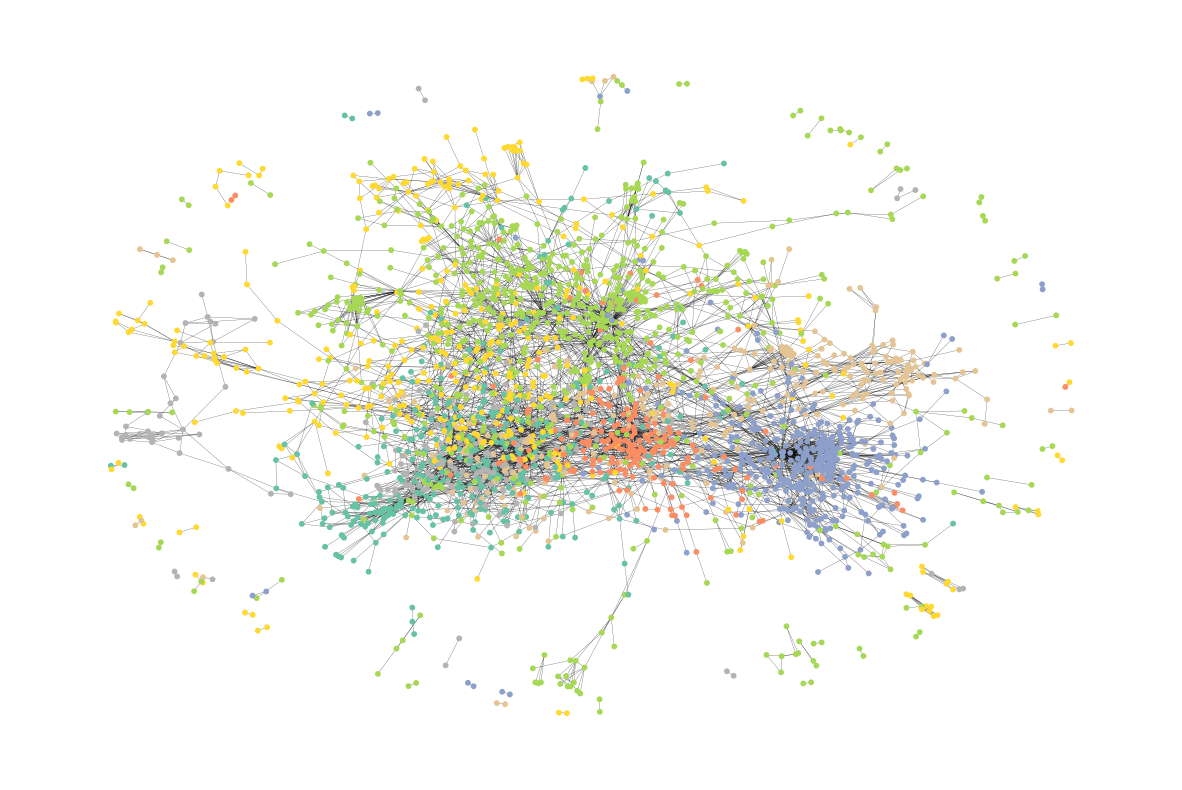

In [11]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

Este dataset empieza a ser lo suficientemente grande como para que con una visualización estática como la ofrecida por Networkx sea insuficiente para apreciarlo bien. Para visualizarlo completamente, es mejor exportar el grafo y visualizarlo en una herramienta externa como [yEd Live](https://www.yworks.com/yed-live/) o [Gephi](https://gephi.org). Aquí exportamos el grafo en formato `graphml` el cual podemos usar para importarlo en las herramientas mencionadas.

También se puede intentar visualizar con librerías interactivas como [pyvis](https://pyvis.readthedocs.io/en/latest/). Pero esto está por fuera el alcance de este notebook.

In [12]:
import matplotlib.cm
import matplotlib.colors

NG = nx.Graph()

for node_id, label in enumerate(data.y):
    color = matplotlib.cm.Set2.colors[label.item()]
    color = matplotlib.colors.rgb2hex(color)
    NG.add_node(node_id, color=color)

for source, target in data.edge_index.T.tolist():
    NG.add_edge(source, target)


nx.write_graphml(NG, 'cora-with-classes.graphml')

Adicional a ello, a manera ilustrativa, vamos a crear un pandas data frame para visualizar la matriz de los nodos y sus features junto con los labels asignados para cada nodo.

In [13]:
import pandas as pd

df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.Series(data.y)
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Definición de la Red para Grafos

En esta sección, definimos el modulo de pytorch lightning que contiene la arquitectura de la red, un MLP simple. Sin embargo, lo importante a resaltar es la definición de los pasos de entrenamiento, validación y prueba.

Primero, recibimos una estructura de datos que hace reference a la matriz **completa** de nodos. Por lo que para respetar el conjunto de validación y prueba, debemos emplear las máscaras definidas para cada conjunto. Adicional a ello, como la una tarea es de clasificación y tenemos 7 clases, definimos una función de CrossEntropy Loss, pero adicional a ello definimos una métrica Accuracy para la valoración del modelo.

Finalmente, hacemos uso de la clase utilitaria `LightningNodeData` para que nos ayude a crear los dataloaders en función de la estructura de los datos de entrada. 

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch_geometric.data.lightning import LightningNodeData
from torchmetrics import Accuracy


class GraphMLP(LightningModule):

    def __init__(self, input_size: int, output_size: int):
        super(GraphMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
            nn.Softmax(dim=1)
        )
        self.train_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.val_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.test_acc = Accuracy(task='multiclass', num_classes=output_size)

        self.hparams['network'] = str(self.network)
        self.save_hyperparameters()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)
    

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        y_hat = self(x)
        loss = F.cross_entropy(y_hat[batch.train_mask], y[batch.train_mask])
        self.train_acc(y_hat[batch.train_mask], y[batch.train_mask])
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        y_hat = self(x)
        self.val_acc(y_hat[batch.val_mask], y[batch.val_mask])
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        y_hat = self(x)
        self.test_acc(y_hat[batch.test_mask], y[batch.test_mask])
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
    

mlp_model = GraphMLP(dataset.num_features, dataset.num_classes)
tb_logger = TensorBoardLogger('tb_logs', name='GraphMLP')
callbacks=[EarlyStopping(monitor='train-loss', patience=3, mode='min')]
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger, callbacks=callbacks)

datamodule = LightningNodeData(
    data,
    input_train_nodes=data.train_mask,
    input_val_nodes=data.val_mask,
    input_test_nodes=data.test_mask,
    loader='neighbor',
    num_neighbors=[25, 10],
    batch_size=1024,
    num_workers=8
)
trainer.fit(mlp_model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | network   | Sequential         | 23.1 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s, v_num=2, val-acc=0.516, train-loss=1.170, train-acc=1.000]


Al terminar el entrenamiento, vemos que la red ha alcanzado una correctitud del $100\%$ en el conjunto de entrenamiento, pero solo un $51\%$ en el conjunto de validación. La red es muy buena mara memorizar los nodos de entrenamiento pero sufre de overfitting.

Ahora evaluemos el modelo en el conjunto de prueba.

In [15]:
mlp_model.eval()
result = trainer.test(mlp_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.5329999923706055
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No es mucho mejor que en el conjunto de validación, confirmando el problema de overfitting que tiene la red. Ahora observemos el proceso de entrenamiento en Tensorboard.

In [16]:
%load_ext tensorboard

In [17]:
%tensorboard --logdir tb_logs/

### Haciendo predicciones

Ahora hagamos uso del modelo. Primero, visualicemos el grafo correspondiente a los nodos de prueba. Para mayor simplicidad, solo visualizaremos los nodos y sus conexiones exclusivamente en el conjunto de prueba.

In [18]:
test_indices = data.test_mask.nonzero(as_tuple=False).squeeze()
test_nodes = data.x
test_edges = data.edge_index[:, test_indices.tolist()].T.tolist()
test_y = data.y[data.test_mask]

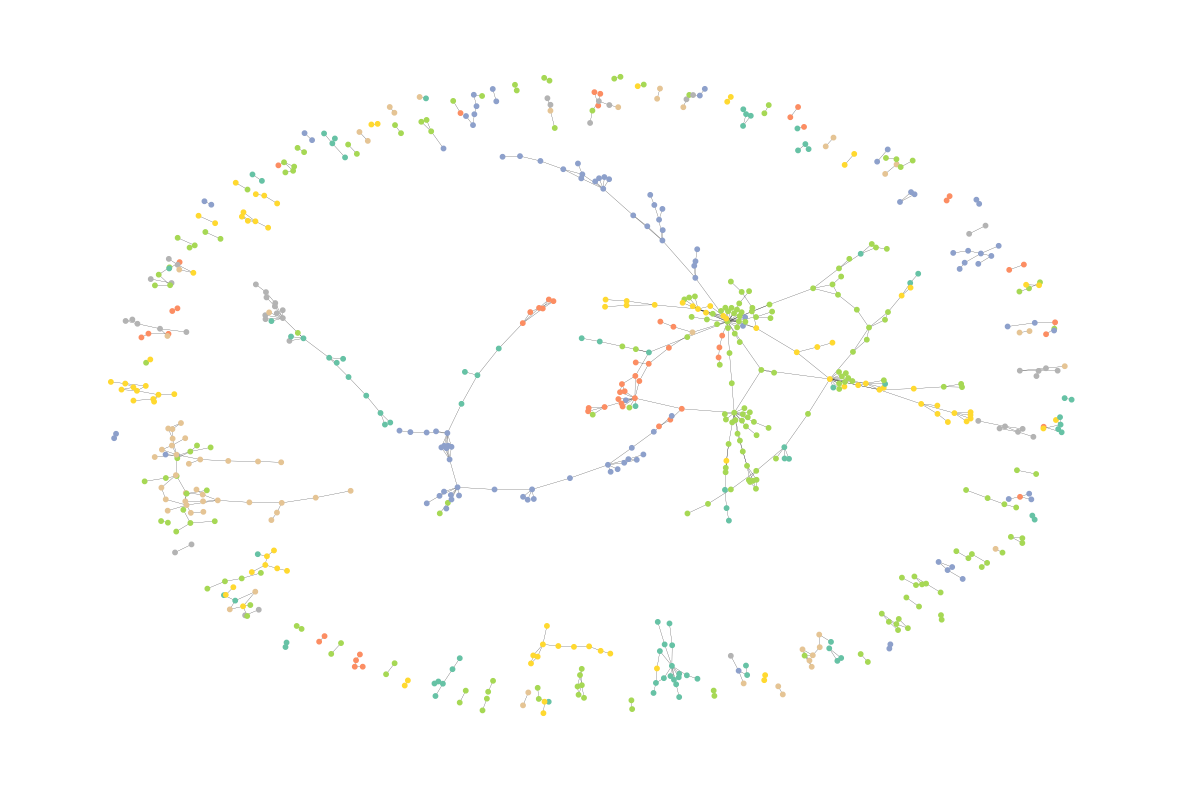

In [19]:
test_graph = nx.Graph()

for source, target in data.edge_index.T.tolist():
    if data.test_mask[source] and data.test_mask[target]:
        test_graph.add_edge(source, target)

colors = []
for node in test_graph.nodes:
    colors.append(data.y[node])


visualize_graph(test_graph, colors)


Ahora, haremos lo mismo con las predicciones del modelo.

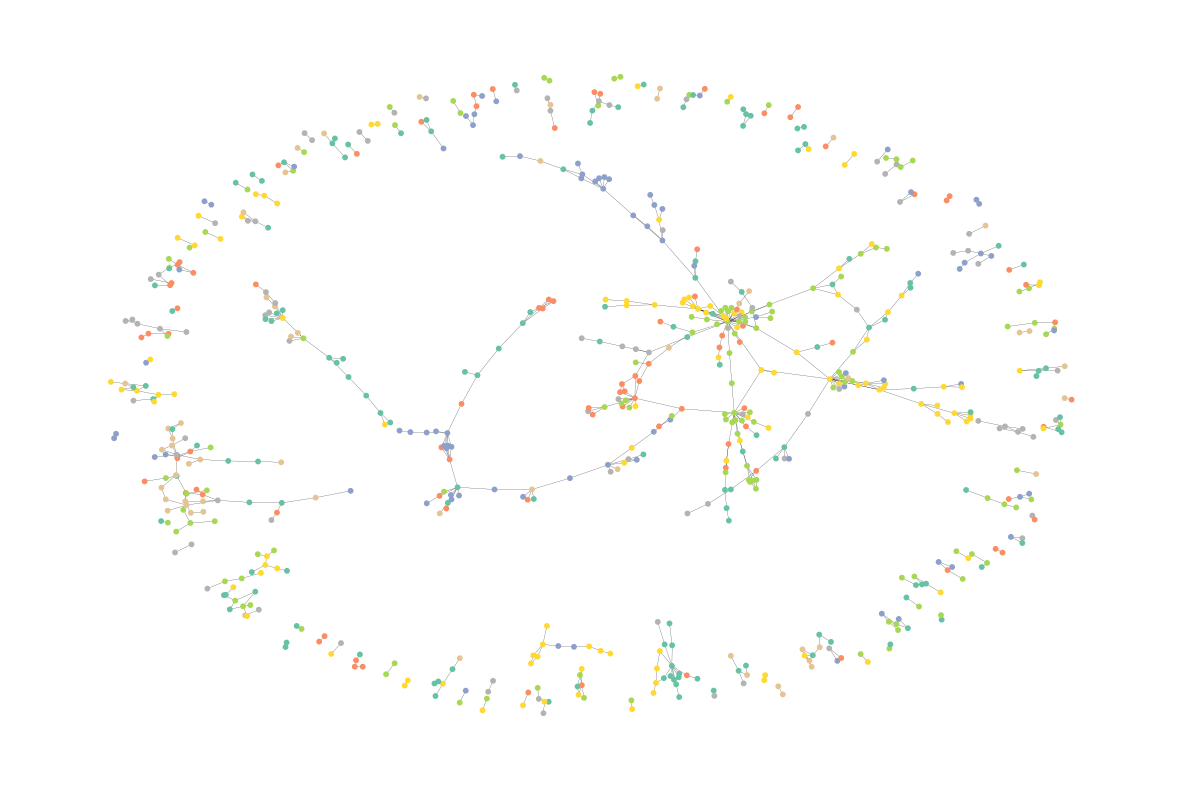

In [20]:
predictions = mlp_model(data.x[data.test_mask])
predictions = torch.argmax(predictions, dim=1)

pred_graph = nx.Graph()

for source, target in data.edge_index.T.tolist():
    if data.test_mask[source] and data.test_mask[target]:
        pred_graph.add_edge(source, target)

colors = []
node_preds = dict(zip(test_indices.tolist(), predictions.tolist()))
for node in pred_graph.nodes:
    colors.append(node_preds[node])

visualize_graph(pred_graph, colors)


## Conclusiones

De primera mano podemos observar que el modelo en efecto pareciera que tiende a acertar la mitad de los nodos, lo cual es mejor que el baseline del $30\%$ (correspondiente a la clase mayoritaria), pero no lo hace un modelo robusto.

Si nos fijamos, lo único que hemos hecho es entrenar un modelo denso pasando como datos de entrada únicamente los features de cada nodo de forma individual. No hemos explorado las relaciones de los nodos. Esto es precisamente de lo que tratan las GNN y lo que veremos a continuación.